In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("Sustainability_Data.csv")

exclude_columns = ['Country']

# Convert only numeric columns to floats, preserving NaNs where present
for col in df.columns:
    if col not in exclude_columns:
        print(col)
        df[col] = pd.to_numeric(df[col], errors='coerce')

Year
Carbon_dioxide_emissions
Electricity_production_non_renewable
Electricity production_renewable
Micro_air_pollution
Greenhouse_emission


In [69]:
df

,Country,Year,Carbon_dioxide_emissions,Electricity_production_non_renewable,Electricity production_renewable,Micro_air_pollution,Greenhouse_emission
0,Afghanistan,1971,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1972,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1973,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1974,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1975,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
14106,Zimbabwe,2019,-37.577859,NaN,NaN,18.528607,-14.342657
14107,Zimbabwe,2020,-49.243405,NaN,NaN,19.494180,-19.641093
14108,Zimbabwe,2021,-44.561198,NaN,NaN,NaN,-16.281414
14109,Zimbabwe,2022,-41.199510,NaN,NaN,NaN,-14.395746


In [70]:
df.dtypes

Country                                  object
Year                                      int64
Carbon_dioxide_emissions                float64
Electricity_production_non_renewable    float64
Electricity production_renewable        float64
Micro_air_pollution                     float64
Greenhouse_emission                     float64
dtype: object

In [4]:
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Define hyperparameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1,0.5,0.3]
}

In [5]:
rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

X = df.dropna()
X_features = X.drop(columns=categorical_cols)

random_search.fit(X_features, X_features)
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 10}


In [73]:
X_features

,Year,Carbon_dioxide_emissions,Electricity_production_non_renewable,Electricity production_renewable,Micro_air_pollution,Greenhouse_emission
179,1991,-34.087011,7.857517,0.000000,22.703110,-21.519163
180,1992,-64.429702,4.949912,0.000000,22.482896,-46.578763
181,1993,-66.541806,6.092377,0.000000,22.297132,-46.239803
182,1994,-64.715528,4.313626,0.000000,22.142012,-40.217420
183,1995,-68.838945,6.013861,0.000000,22.013731,-43.322670
...,...,...,...,...,...,...
14098,2011,-31.406618,42.144097,1.421441,23.616283,-10.804688
14099,2012,-28.373334,39.606650,1.825492,23.539528,-8.383584
14100,2013,-26.567398,46.060606,1.734587,22.598401,-6.615451
14101,2014,-27.370867,44.394574,1.436266,23.429253,-12.963752


In [74]:
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    ),
    random_state=42
)

df_imputed_rf = pd.DataFrame(rf_imputer.fit_transform(df), columns=df.columns)

for col in categorical_cols:
    df_imputed_rf[col] = label_encoders[col].inverse_transform(df_imputed_rf[col].astype(int))

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [75]:
df_imputed_rf

,Country,Year,Carbon_dioxide_emissions,Electricity_production_non_renewable,Electricity production_renewable,Micro_air_pollution,Greenhouse_emission
0,Afghanistan,1971.0,143.727584,48.504225,11.413696,20.632061,52.344529
1,Afghanistan,1972.0,151.795678,47.933665,11.153545,20.177740,51.672564
2,Afghanistan,1973.0,152.305306,48.422390,11.262863,20.162455,52.457111
3,Afghanistan,1974.0,151.840462,47.724733,11.263304,20.287243,51.906634
4,Afghanistan,1975.0,153.131476,49.031468,11.220013,19.957146,52.287968
...,...,...,...,...,...,...,...
14106,Zimbabwe,2019.0,-37.577859,49.495706,2.992082,18.528607,-14.342657
14107,Zimbabwe,2020.0,-49.243405,44.898425,2.460127,19.494180,-19.641093
14108,Zimbabwe,2021.0,-44.561198,47.076263,2.599768,20.042271,-16.281414
14109,Zimbabwe,2022.0,-41.199510,48.616702,2.706582,19.432285,-14.395746


In [77]:
df_imputed_rf.to_csv("Imputed_Sustainability_Data.csv")

#### Imputer Evaluation

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


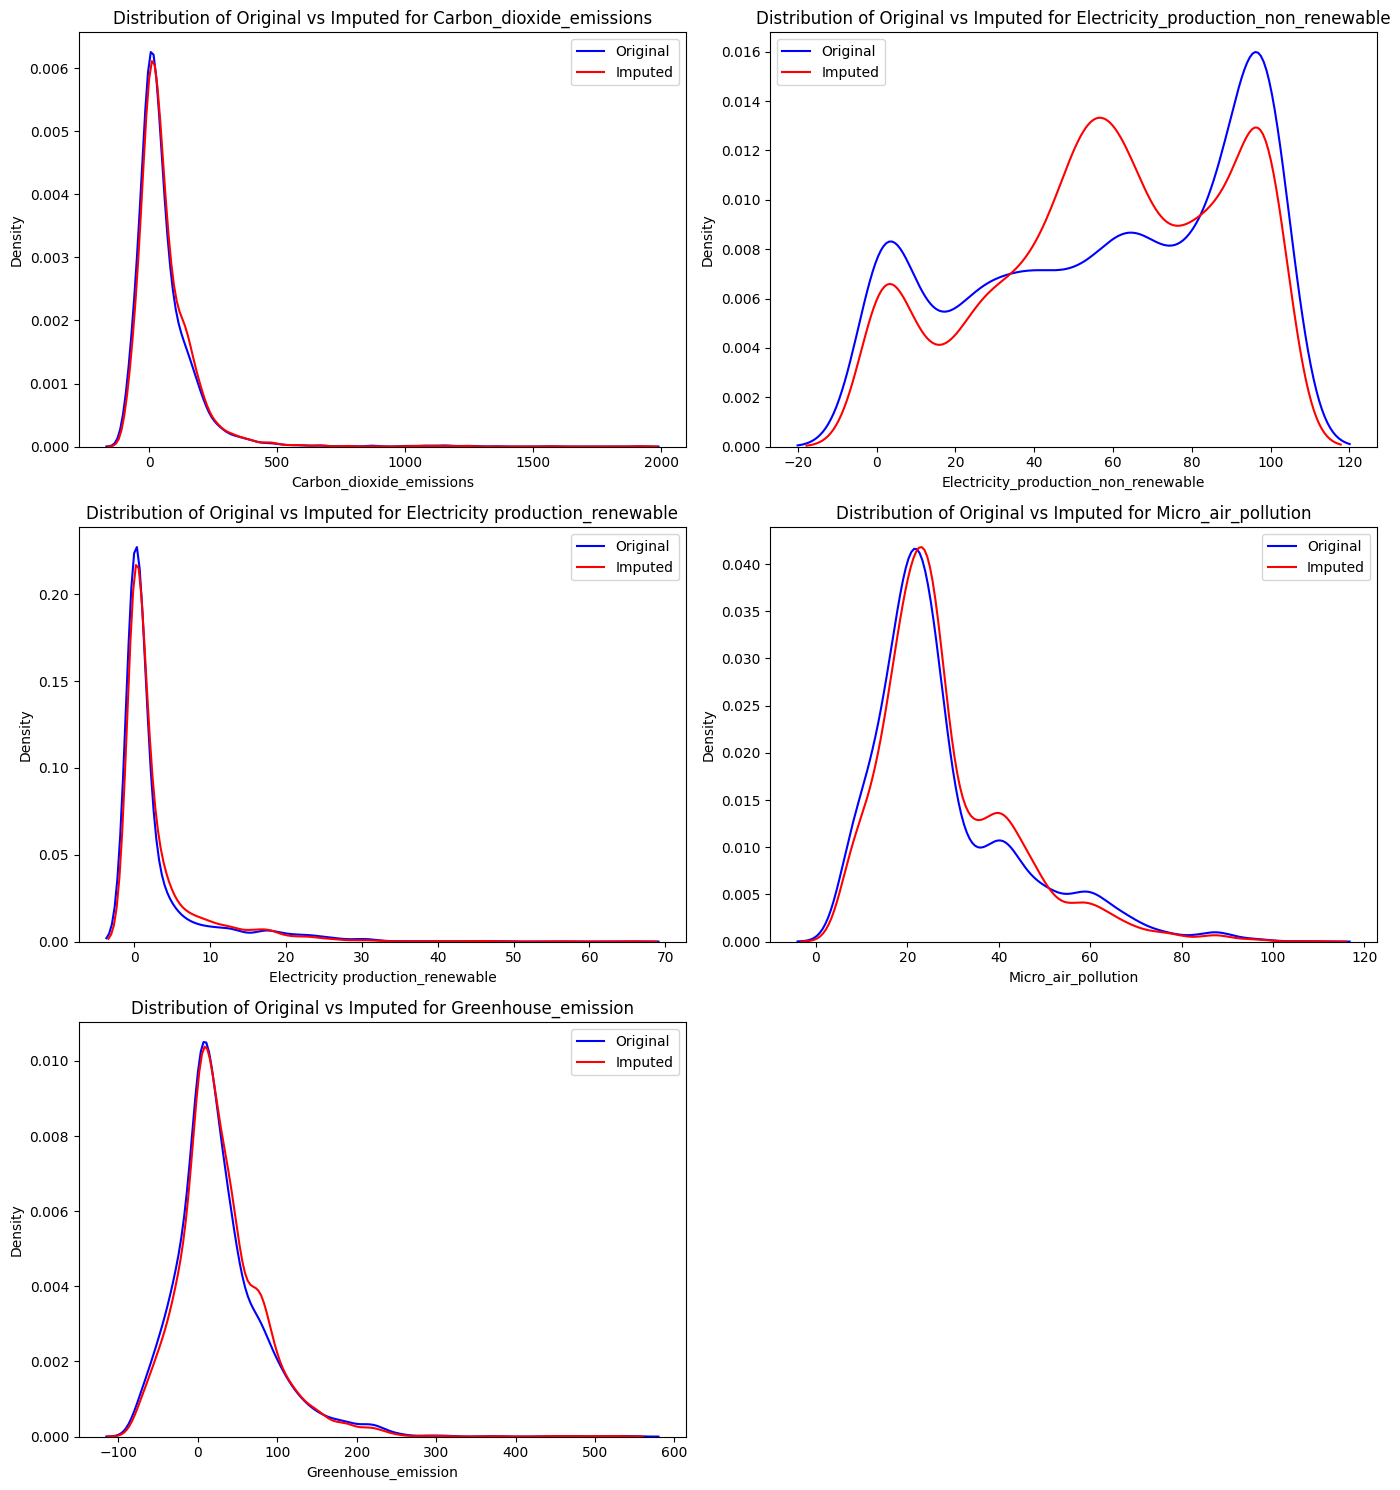

                                 target       R^2       RMSE        MAE
0              Carbon_dioxide_emissions  0.807898  56.709205  15.832174
1  Electricity_production_non_renewable  0.770248  16.301554   7.274646
2      Electricity production_renewable  0.724599   3.238138   1.027750
3                   Micro_air_pollution  0.772567   7.777752   3.120000
4                   Greenhouse_emission  0.838194  23.665324   7.728797


In [76]:
# Load data
synthetic_data = pd.read_csv('synthetic_data_sustainability.csv')
full_data = pd.read_csv('synthetic_data_sustainability_full.csv')

# Configure and fit the imputer
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=29
    ),
    random_state=29
)
synthetic_data_imputed = pd.DataFrame(rf_imputer.fit_transform(synthetic_data), columns=synthetic_data.columns)

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}
missing_columns = synthetic_data.columns[synthetic_data.isnull().any()]

# Set up subplots
num_columns = len(missing_columns)
fig, axes = plt.subplots(nrows=num_columns // 2 + num_columns % 2, ncols=2, figsize=(14, num_columns * 3))
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each column with missing values
for idx, column in enumerate(missing_columns):
    y_true = full_data[column]
    y_pred = synthetic_data_imputed[column]

    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Append metrics for this target
    metrics['target'].append(column)
    metrics['R^2'].append(r2)
    metrics['RMSE'].append(rmse)
    metrics['MAE'].append(mae)
    
    # Plot distribution comparison in subplots
    sns.kdeplot(y_true, label='Original', color='blue', ax=axes[idx])
    sns.kdeplot(y_pred, label='Imputed', color='red', ax=axes[idx])
    axes[idx].set_title(f"Distribution of Original vs Imputed for {column}")
    axes[idx].set_xlabel(column)
    axes[idx].legend()

# Remove any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

In [8]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns



# Load the full dataset
full_data = pd.read_csv('synthetic_data_sustainability_full.csv')

# Split the full data into 60-40 for training and testing

train_data, test_data = train_test_split(full_data, test_size=0.4, random_state=29)

# Create synthetic missing data in the test set by randomly setting values to NaN
np.random.seed(29)
missing_fraction = 0.3  # 70% of the data will be randomly masked as NaN
for column in test_data.columns:
    mask = np.random.rand(test_data.shape[0]) < missing_fraction
    test_data.loc[mask, column] = np.nan

# Initialize metrics storage
metrics = {'target': [], 'R^2': [], 'RMSE': [], 'MAE': []}

# Perform imputation and evaluation over 30 runs
for run in range(30):
    # Initialize Iterative Imputer with RandomForestRegressor using best parameters
    rf_imputer = IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            max_features=best_params['max_features'],
            random_state=29 + run
        ),
        random_state=29 + run
    )

    # Perform imputation on the test data
    test_data_imputed = pd.DataFrame(rf_imputer.fit_transform(test_data), columns=test_data.columns)

    # Calculate metrics for each column with synthetic missing values
    missing_columns = test_data.columns[test_data.isnull().any()]

    for column in missing_columns:
        y_true = full_data.loc[test_data.index, column]  # Use the original full data as ground truth
        y_pred = test_data_imputed[column]

        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        # Append metrics for this target
        metrics['target'].append(column)
        metrics['R^2'].append(r2)
        metrics['RMSE'].append(rmse)
        metrics['MAE'].append(mae)

# Display metrics as a DataFrame
metrics_df = pd.DataFrame(metrics)


metrics_summary = metrics_df.groupby('target').agg(
    R2_mean=('R^2', 'mean'),
    R2_std=('R^2', 'std'),
    RMSE_mean=('RMSE', 'mean'),
    RMSE_std=('RMSE', 'std'),
    MAE_mean=('MAE', 'mean'),
    MAE_std=('MAE', 'std')
).reset_index()

print(metrics_summary)

C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [Itera

                                 target   R2_mean    R2_std  RMSE_mean  \
0              Carbon_dioxide_emissions  0.712178  0.004852  68.862502   
1      Electricity production_renewable  0.727676  0.010966   3.082091   
2  Electricity_production_non_renewable  0.711880  0.005265  18.172965   
3                   Greenhouse_emission  0.832755  0.005161  24.020009   
4                   Micro_air_pollution  0.776708  0.005527   7.568512   

   RMSE_std   MAE_mean   MAE_std  
0  0.579564  15.625994  0.309338  
1  0.061584   0.954177  0.014542  
2  0.165865   8.654026  0.083115  
3  0.370173   7.403067  0.105676  
4  0.093708   2.936751  0.033092  


C:\Users\Tanay\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
